<a href="https://colab.research.google.com/github/Izeple/100-Days-Of-ML-Code/blob/master/Project_imageC_v2_1_coco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project : Image Captioning <br>
Goal : ต้องการสร้างคำอธิบายรูปภาพเป็นภาษาอังกฤษจากรูปภาพ<br>
เทคนิค: CNN+LSTM<br>
Data ที่ใช้: MSCOCO <br>

สมาชิกกลุ่ม<br>
1.นายธนกฤต 	รุ่งเรืองสิริกัลยาณ์	60070501017<br>
2.นายธนิษฐ์ 		อัญชลีชไมกร   	60070501022<br>
3.นางสาวภัทรพร 	ธนัชศิริธีรเดช		60070501041<br>

https://www.kaggle.com/hsankesara/flickr-image-dataset 


ref <br>
*   import Dataset from kaggle to colab <br>
    https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a
*   kaggle https://www.kaggle.com/wikiabhi/image-caption-generator




# 1. Setup

## Import library

In [ ]:
import os
import glob
import string
import numpy as np
import pandas as pd
from PIL import Image
from IPython.display import Image, display
import pickle
from pickle import dump, load
from numpy import array
from numpy import argmax
import collections
import random
import time
import json

from keras.applications.xception import Xception, preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from keras.utils import plot_model
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.callbacks import ModelCheckpoint

from nltk.translate.bleu_score import corpus_bleu

# small library for seeing the progress of loops.
#from tqdm.notebook import tqdm as tqdm        #from tqdm import tqdm_notebook as tqdm
#tqdm().pandas()

## Connect colab with google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Changing the working directory

In [ ]:
# Check the present working directory
%pwd

'/content'

In [ ]:
# Changing the working directory
%cd "/content/drive/MyDrive/ProjectAI/MSCOCO"

/content/drive/MyDrive/ProjectAI/MSCOCO


In [ ]:
# Check the present working directory
%pwd

'/content/drive/MyDrive/ProjectAI/MSCOCO'

In [ ]:
# Check file
!ls

annotations_trainval2017      model_1.h5  test2017.zip
annotations_trainval2017.zip  model_2.h5  train2017
descriptions.txt	      model_3.h5  train2017.zip
features_xception_test	      model_4.h5  val2017
features_xception_train       model.png   val2017.zip
features_xception_val	      pickle
model_0.h5		      test2017


## Load Dataset MSCOCO to google drive

*   Train images: http://images.cocodataset.org/zips/train2017.zip
*   Val images: http://images.cocodataset.org/zips/val2017.zip
*   Test images: http://images.cocodataset.org/zips/test2017.zip
*   Train/Val Annotations: http://images.cocodataset.org/annotations/annotations_trainval2017.zip
*   COCO : https://cocodataset.org/




In [ ]:
# Download Coco dataset(train & val) to google drive
#!wget -P ./drive/MyDrive/ProjectAI/MSCOCO http://images.cocodataset.org/zips/train2017.zip
#!wget -P ./drive/MyDrive/ProjectAI/MSCOCO http://images.cocodataset.org/zips/val2017.zip
#!wget -P ./drive/MyDrive/ProjectAI/MSCOCO http://images.cocodataset.org/zips/test2017.zip
#!wget -P ./drive/MyDrive/ProjectAI/MSCOCO http://images.cocodataset.org/annotations/annotations_trainval2017.zip

In [ ]:
# unzipping the zip files     -q = verbose0 (not show progress)
#!unzip -q train2017.zip
#!unzip -q val2017.zip
#!unzip -q test2017.zip
#!unzip -q annotations_trainval2017.zip

# 2. Prepare Photo Data

## List all name picture in directory

In [ ]:
#directory = './train2017/'
#images_list = os.listdir(directory)
#dump(images_list, open("./pickle/images_list.pkl", "wb"))          # save images_list.pkl

images_list = pickle.load(open("./pickle/images_list.pkl", "rb"))   # load images_list.pkl
len(images_list)

30781

## Extract features by VGG

In [ ]:
# Extract features from each photo in the directory
def extract_features_vgg(directory,start,stop):
    model = VGG16()       
    model.layers.pop()                                                              # ลบเลเยอร์สุดท้ายที่เป็น classification ออก 
    model.add(layers.Dense(2048, activation="relu"))
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)             # แล้วจะกลายเป็นโมเดล encoder ที่สร้าง features ของรูปภาพ
    list_dir = os.listdir(directory)

    features = dict()                                                               # สร้าง features ให้เป็น dictionary
    for name in list_dir[start:stop]:
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))                          # โหลดรูปแล้วแปลงให้มีขนาด 224*224
        image = img_to_array(image)                                                 # แปลงจาก pixels ให้เป็น numpy array
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))  # reshape ให้พร้อมเข้าโมเดล
        image = preprocess_input(image)                                             # เป็น preprocess สำเร็จรูปของ VGG  
        feature = model.predict(image, verbose=0)                                   # ให้โมเดล สร้าง features ออกมา
        image_id = name.split('.')[0]                                               # เอาชื่อไฟล์ภาพ มาเป็น key ของ features 
        features[image_id] = feature
    return features

In [ ]:
# get feature from flickr30k_images by vgg
''' 
for i in range(0,len(train_images_list),1000):                                     # แบ่งเทรนทีละ 1000 แล้ว save .pkl เพราะว่า ทำทีเดียว 28000 จะเจอปัญหาเยอะ timeout, memmory เต็ม
    print(i,i+1000)
    features = extract_features_vgg(directory,i,i+1000)
    dump(features, open('./features_vgg/features_vgg_'+str(i)+'.pkl', 'wb'))       # เชฟออกมาเป็นไฟล์ pickle
'''
#print('Extracted Features: ', len(features))

" \nfor i in range(0,len(train_images_list),1000):                                     # แบ่งเทรนทีละ 1000 แล้ว save .pkl เพราะว่า ทำทีเดียว 28000 จะเจอปัญหาเยอะ timeout, memmory เต็ม\n    print(i,i+1000)\n    features = extract_features_vgg(directory,i,i+1000)\n    dump(features, open('./features_vgg/features_vgg_'+str(i)+'.pkl', 'wb'))       # เชฟออกมาเป็นไฟล์ pickle\n"

In [ ]:
# load *.pkl and merge to features_vgg.pkl
'''
features_vgg = {}
for filename in glob.glob('./features_vgg/*.pkl'):    #รวมไฟล์ที่แบ่ง train เป็นไฟล์ .pkl ไฟล์เดียว
    with open(filename, 'rb') as f:
      d = pickle.load(f)
    features_vgg.update(d)

dump(features_vgg, open('features_vgg.pkl', 'wb'))
len(features_vgg)
'''

"\nfeatures_vgg = {}\nfor filename in glob.glob('./features_vgg/*.pkl'):\n    with open(filename, 'rb') as f:\n      d = pickle.load(f)\n    features_vgg.update(d)\n\ndump(features_vgg, open('features_vgg.pkl', 'wb'))\nlen(features_vgg)\n"

In [ ]:
# load features_vgg.pkl       เนื่องจาก　การทำ features extraction ใช้เวลานาน จึงได้ทำการเทรนwไว้ก่อนแล้ว แล้วเก็บเป็น ไฟล์ .pkl พร้อมโหลดมาใช้งานได้ตลอด
'''
with open("features_vgg.pkl", 'rb') as f:
      features_vgg = pickle.load(f)
len(features_vgg)
'''

'\nwith open("features_vgg.pkl", \'rb\') as f:\n      features_vgg = pickle.load(f)\nlen(features_vgg)\n'

In [ ]:
# Plot the model architecture
#plot_model(VGG16(), to_file='VGG.png', show_shapes=True)

## Extract features by Xception

In [ ]:
# Xception
def extract_features_xception(directory,start,stop):
    model = Xception( include_top=False, pooling='avg')
    features = {}
    list_dir = os.listdir(directory)
    for img in list_dir[start:stop]:
        filename = directory + "/" + img
        try:
            image = load_img(filename, target_size=(299, 299))
            image = np.expand_dims(image, axis=0)
            image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0
        except Exception:
            pass
        
        feature = model.predict(image)
        features[img] = feature
    return features

In [ ]:
# get feature from coco_train_image by xception
'''
directory = './val2017/'

train_images_list = os.listdir(directory)
for i in range(0,len(train_images_list),1000):                # แบ่งเทรนทีละ 1000 เพราะว่า ทำ 28000 เจอปัญหาเยอะ timeout, memmoryเต็ม
    print(i,i+1000)
    features = extract_features_xception(directory,i,i+1000)
    dump(features, open('./features_xception_val/features_xception_'+str(i)+'.p', 'wb'))       # เชฟออกมาเป็นไฟล์ pickle
print('Extracted Features: ', len(features))
'''

"\ndirectory = './val2017/'\n\ntrain_images_list = os.listdir(directory)\nfor i in range(0,len(train_images_list),1000):                # แบ่งเทรนทีละ 1000 เพราะว่า ทำ 28000 เจอปัญหาเยอะ timeout, memmoryเต็ม\n    print(i,i+1000)\n    features = extract_features_xception(directory,i,i+1000)\n    dump(features, open('./features_xception_val/features_xception_'+str(i)+'.p', 'wb'))       # เชฟออกมาเป็นไฟล์ pickle\nprint('Extracted Features: ', len(features))\n"

In [ ]:
# load *.pkl and merge to features_xeception.pkl
'''
features_xeception = {}
for filename in glob.glob('./features_xception_val/*.p'):
    with open(filename, 'rb') as f:
      d = pickle.load(f)
    features_xeception.update(d)

dump(features_xeception, open('./pickle/features_xception_val.pkl', 'wb'))
len(features_xeception)
'''

"\nfeatures_xeception = {}\nfor filename in glob.glob('./features_xception_val/*.p'):\n    with open(filename, 'rb') as f:\n      d = pickle.load(f)\n    features_xeception.update(d)\n\ndump(features_xeception, open('./pickle/features_xception_val.pkl', 'wb'))\nlen(features_xeception)\n"

In [ ]:
# load *.pkl　from dir_load and then merge it save to dir_save
'''
def merge_pkl(dir_load,dir_save):
    pkl_file = {}
    for filename in glob.glob(dir_load):
        with open(filename, 'rb') as f:
          d = pickle.load(f)
        pkl_file.update(d)

    dump(pkl_file, open(dir_save, 'wb'))
    print(len(pkl_file))

merge_pkl(dir_load='./features_xception_test/*.p', dir_save='./pickle/features_xception_test.pkl')
'''

"\ndef merge_pkl(dir_load,dir_save):\n    pkl_file = {}\n    for filename in glob.glob(dir_load):\n        with open(filename, 'rb') as f:\n          d = pickle.load(f)\n        pkl_file.update(d)\n\n    dump(pkl_file, open(dir_save, 'wb'))\n    print(len(pkl_file))\n\nmerge_pkl(dir_load='./features_xception_test/*.p', dir_save='./pickle/features_xception_test.pkl')\n"

In [ ]:
# load features_xception.pkl
with open("./pickle/features_xception_test.pkl", 'rb') as f:
      features_xception_test = pickle.load(f)
print("features_xception_test",len(features_xception_test))

with open("./pickle/features_xception_train.pkl", 'rb') as f:
      features_xception_train = pickle.load(f)
print("features_xception_train",len(features_xception_train))

with open("./pickle/features_xception_val.pkl", 'rb') as f:
      features_xception_val = pickle.load(f)
print("features_xception_val",len(features_xception_val))

features_xception_test 40970
features_xception_train 30781
features_xception_val 5000


# 3. Prepare text Data

## Defining function

In [ ]:
def load_doc(filename):
    file = open(filename, 'r')  # เปิดไฟล์ แบบ "อ่านอย่างเดียว"
    text = file.read()          # อ่านไฟล์มาเก็บในตัวแปร text
    file.close()                # ปิดไฟล์ เพื่อไม่ให้เปลืองเมมโมรี่
    return text                 # ส่งข้อความที่อ่านได้กลับไป

In [ ]:
def clean_descriptions(description_mapping):
    table = str.maketrans('','', string.punctuation)                        # เตรียมตาราง translation เพื่อไว้ลบ punctuation
    
    # Traversing through the mapping we created
    for key, descriptions in description_mapping.items():
        for i in range(len(descriptions)):                                  # วนลูป คำอธิบายทั้งหมด ต่อ 1 รูปภาพที่ mapping ด้วย
            description = descriptions[i]                                   # คัดลอกใส่ตัวแปร เพื่อทำการ clean
            description = description.split()                               # split string ให้กลายเป็น list คำศัพท์
            description = [word.lower() for word in description]            # แปลงให้เป็น lower case
            description = [word.translate(table) for word in description]   # ลบพวก punctuation เช่น ,& โดยใช้ translation table 
            description = [word for word in description if len(word)>1]     # ลบคำศัพท์ที่มี ตัวอักษรอยู่ตัวเดียว
            description = [word for word in description if word.isalpha()]  # ลบคำศัพท์ที่มีตัวเลขผสมอยู่
            description = ["<start>"] + description + ["<end>"]
            descriptions[i] = ' '.join(description)                         # join list กลับให้กลายเป็น string เหมือนเดิม

In [ ]:
# Converting the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

In [ ]:
# dict description mapping with photo
def dict_description_to_image_mapping(dict_description,train_images_list):
    dict_mapping = dict()                                     # สร้าง dict ที่จะเอาไว้ map รูป กับ คำอธิบายเข้าด้วยกัน
    for key in dict_description.keys():                     
        if key in train_images_list:                            # เช็คดูก่อนว่า คำอธิบายรูปนี้ มีรูปภาพในโฟล์เดอร์อยู่ไหม
            dict_mapping[key] = dict_description[key]
    return dict_mapping

In [ ]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)

    file.close()

## Parsing descriptions

In [ ]:
# load json data
f = open('./annotations_trainval2017/captions_train2017.json',) 
data = json.load(f)
f.close() 
print(data.keys())

# Group all captions together having the same image ID.
dict_description = collections.defaultdict(list)
for val in data['annotations']:
  #caption = f"<start> {val['caption']} <end>"
  caption = f"{val['caption']}"
  image_path = '%012d.jpg' % (val['image_id'])
  dict_description[image_path].append(caption)

# convert to DataFrame
pd.DataFrame(list(dict_description.items()),columns = ['image_name','caption'])

dict_keys(['info', 'licenses', 'images', 'annotations'])


,image_name,caption
0,000000203564.jpg,[A bicycle replica with a clock as the front w...
1,000000322141.jpg,[A room with blue walls and a white sink and d...
2,000000016977.jpg,[A car that seems to be parked illegally behin...
3,000000106140.jpg,[A large passenger airplane flying through the...
4,000000571635.jpg,"[A bathroom with a toilet, sink, and shower., ..."
...,...,...
118282,000000464382.jpg,"[A pair of scissors sitting on a table., A pic..."
118283,000000410182.jpg,"[a plate of various food on a table, A plate o..."
118284,000000383652.jpg,[A full fridge door sits open in an empty kitc...
118285,000000133071.jpg,"[Bread, sour cream, and guacamole are arrayed ..."


In [ ]:
# convert dict_discription to 2 list
'''
train_captions = []
img_name_vector = []

image_paths = list(dict_description.keys())
random.shuffle(image_paths)

for image_path in image_paths:
  caption_list = dict_description[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))
'''

'\ntrain_captions = []\nimg_name_vector = []\n\nimage_paths = list(dict_description.keys())\nrandom.shuffle(image_paths)\n\nfor image_path in image_paths:\n  caption_list = dict_description[image_path]\n  train_captions.extend(caption_list)\n  img_name_vector.extend([image_path] * len(caption_list))\n'

In [ ]:
# ไม่ต้องทำก็ได้ เพราะ dataset MSCOCO ทุกรูปภาพมีคำอธิบาย แต่บางคำอธิบายที่ไม่มีรูป(ไฟล์รูป)
train_images_list = images_list

def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 
    

'''


images_list = os.listdir('./train2017/')
train_images_list = intersection(list(dict_description.keys()), images_list)
print("dict image :",len(list(dict_description.keys())))
print("file image :",len(images_list))
print("train image :",len(train_images_list))

'''
# save
dump(train_images_list, open("./pickle/train_images_list.pkl", "wb"))

# คือ มีรูปจริงๆเพียง 30781 รูป แต่มีคำอธิบายมากถึง 118287 รูป

In [ ]:
# แต่ต้องทำอันนี้ มันคือการ mapping คำอธิบายที่มีรูปภาพจริงๆ เป็น train_description
train_descriptions = dict_description_to_image_mapping(dict_description,train_images_list)
print(len(list(train_descriptions.keys())))

30781


## Preprocess the captions

In [ ]:
# Preprocess the captions
clean_descriptions(train_descriptions)                                    # Cleaning the descriptions
dump(train_descriptions, open("./pickle/train_descriptions.pkl", "wb"))   # save
#save_descriptions(train_descriptions, 'descriptions.txt')
print('Length of descriptions : %d ' % len(train_descriptions))

vocabulary = to_vocabulary(train_descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

Length of descriptions : 30781 
Vocabulary Size: 15952


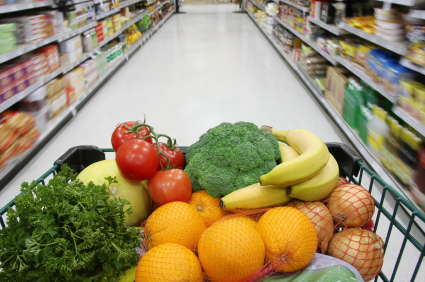

<start> grocery basket full if fruit and vegetables walking in store <end>
<start> bunch of veggies and fruit in shopping cart <end>
<start> shopping cart is full of fruits and vegetables <end>
<start> shopping cart full of fruits and vegetables <end>
<start> shopping cart is full of colorful produce <end>


[None, None, None, None, None]

In [ ]:
from PIL import Image
rand = random.randint(0,len(train_images_list))
image_name = list(train_descriptions.keys())[rand]
img = Image.open("./train2017/"+image_name)
display(img)
[print(a) for a in train_descriptions[image_name]]

# 4. Developing Deep Learning Model

## Defining function

In [ ]:
def load_file(filename):             # ฟังก์ชั่นอ่านข้อความในไฟล์ แล้ว close ให้เพื่อไม่ให้เปลืองพื้นที่
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

def load_photo_features(filename, photos):                              # ฟังก์ชั่นโหลด feature (ตามชื่อของไฟล์รูปที่ใส่เข้ามา)
    all_features = load(open(filename, 'rb'))
    features = {k: all_features[k] for k in photos}                  
    return features

In [ ]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# แปลงคำอธิบายที่เป็น text ให้อยู่ในรูปแบบ ตัวเลข ผ่านวิธีการ encoder เพื่อให้โมเดลสามารถเรียนรู้ได้
# ซึ่งการ encoder จะต้องสร้างตัวเลขที่เฉพาะเจาะจงให้แต่ละคำศัพท์ โดยถ้าคำศัพท์ที่มีความใกล้เคียงกัน แล้วทำให้มีตัวเลขที่ใกล้เคียงกันจะยิ่งทำให้ฉลาดขึ้น
# ถึงในส่วนนี้ ทาง keras มีฟังก์ชั่น Tokenizer ให้เรียกใช้แล้ว

def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
#calculated the length of description with most words
def max_lengthTEMP(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

## Defining the Model

The model is in three parts:

Photo Feature Extractor: 16-layer VGG 

Sequence Processor: This is a word embedding layer for handling the text input, followed by a Long Short-Term Memory (LSTM) recurrent neural network layer.

Decoder: Both the feature extractor and sequence processor output a fixed-length vector. These are merged together and processed by a Dense layer to make a final prediction. The Photo Feature Extractor model expects input photo features to be a vector of 4,096 elements. These are processed by a Dense layer to produce a 256 element representation of the photo.

The Sequence Processor model expects input sequences with a pre-defined length (34 words) which are fed into an Embedding layer that uses a mask to ignore padded values. This is followed by an LSTM layer with 256 memory units.

Both the input models produce a 256 element vector. Further, both input models use regularization in the form of 50% dropout. This is to reduce overfitting the training dataset, as this model configuration learns very fast.

The Decoder model merges the vectors from both input models using an addition operation. This is then fed to a Dense 256 neuron layer and then to a final output Dense layer that makes a softmax prediction over the entire output vocabulary for the next word in the sequence.

In [ ]:
#the below function loop forever with a while loop and within this, 
#loop over each image in the image directory. 
#For each image filename, we can load the image and 
#create all of the input-output sequence pairs from the image’s description.

#data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            photo = photos[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, photo)
            yield ([input_image, input_sequence], output_word)

#data generator, intended to be used in a call to model.fit_generator()
def data_generator_list(descriptions, photos, tokenizer, max_length):
    input_image = []
    input_sequence = []
    output_word = []
    for key, description_list in descriptions.items():
        #retrieve photo features
        photo = photos[key][0]
        ii_, is_, ow_ = create_sequences(tokenizer, max_length, description_list, photo)
        input_image.append(ii_)
        input_sequence.append(is_)
        output_word.append(ow_)
    return input_image, input_sequence, output_word

#we are calling the create_sequence() function to create 
#a batch worth of data for a single photo rather than an entire dataset. 
#This means that we must update the create_sequences() function 
#to delete the “iterate over all descriptions” for-loop.            
#Updated create sequence function for data_generator
def create_sequences(tokenizer, max_length, desc_list, photo):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)

In [ ]:
from keras.utils import plot_model
# define the captioning model
def define_model(vocab_size, max_length):
    
    # feature extractor model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    
    return model

## coding

In [ ]:
# tokenizer
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open("./pickle/tokenizer.pkl", "wb"))

# max_length
max_length = max_lengthTEMP(train_descriptions)
dump(max_length, open("./pickle/max_length.pkl", "wb"))

In [ ]:
# load all resorce and create generator

train_images_list = load(open("./pickle/train_images_list.pkl", "rb"))
print('Dataset: ',len(train_images_list))

train_descriptions = load(open("./pickle/train_descriptions.pkl", "rb"))
print('Descriptions: train=', len(train_descriptions))

#train_features = load_photo_features('./pickle/features_xception_train.pkl', train_images_list)           #  (เฉพาะ vgg ที่ใช้ image_list_v2)
train_features = load(open("./pickle/features_xception_train.pkl", "rb"))
print('Photos: train=', len(train_features))

tokenizer = load(open("./pickle/tokenizer.pkl", "rb"))

vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size:', vocab_size)

#max_length = max_lengthTEMP(train_descriptions)
max_length = load(open("./pickle/max_length.pklf", "rb"))
print('Description Length: ', max_length)

generator = data_generator(train_descriptions, train_features, tokenizer, max_length)

Dataset:  5000
Descriptions: train= 30781
Photos: train= 30781
Vocabulary Size: 15951
Description Length:  48


In [ ]:
# define model
model = define_model(vocab_size, max_length)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 48)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 48, 256)      4083456     input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
_______________________________________________________________________________________

In [ ]:
# create floder to save model
!mkdir model

In [ ]:
epochs = 5
steps = len(train_descriptions)

for i in range(epochs):
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model/model_' + str(i) + '.h5')

Instructions for updating:
Please use Model.fit, which supports generators.
 6184/30781 [=====>........................] - ETA: 1:01:47 - loss: 3.6149

KeyboardInterrupt: ignored

# 5. Evaluate the model

In [ ]:
#this function maps an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

#The function below generates a textual description given a trained model, 
#and a given prepared photo as input. It calls the function word_for_id() 
#in order to map an integer prediction back to a word.
def generate_desc(model, tokenizer, photo, max_length):
    in_text = '<start>'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]     # เปลี่ยนจาก text เป็น sequences(ชุดตัวเลข)
        sequence = pad_sequences([sequence], maxlen=max_length)   # padding ในที่นี้คือ การเติม 0 ให้ input มีขนาดเท่ากัน เท่ากับ max_len
        prob = model.predict([photo,sequence], verbose=0)         # ทำนายคำ จากรูปภาพและseqก่อนหน้า
        prob = argmax(prob)                                       # แปลงจากความน่าจะเป็น เป็น ตัวเลขจำนวนเต็ม
        word = word_for_id(prob, tokenizer)                       # map ตัวเลข กับ คำศัพท์
        if word is None:
            break
        in_text += ' ' + word                                     # นำคำที่ถูกทำนายมาต่อท้าย
        if word == '<stop>':
            break
    return in_text

#the below function evaluates the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    for key, desc_list in descriptions.items():
        prediction = generate_desc(model, tokenizer, photos[key], max_length)
        actual_desc = [d.split() for d in desc_list]
        actual.append(actual_desc)
        predicted.append(prediction.split())

    print('BLEU-1: ', corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: ', corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: ', corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: ', corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
    return actual, predicted
def max_length_(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [ ]:
# load all train resorce 
train_images_list = load(open("./pickle/train_images_list.pkl", "rb"))
print('Dataset: ',len(train_images_list))

train_descriptions = load(open("./pickle/train_descriptions.pkl", "rb"))
print('Descriptions: train=', len(train_descriptions))

tokenizer = load(open("./pickle/tokenizer.pkl", "rb"))

vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size:', vocab_size)

max_length = max_lengthTEMP(train_descriptions)
print('Description Length: ', max_length)

Dataset:  5000
Descriptions: train= 30781
Vocabulary Size: 15951
Description Length:  48


## Prepare val text data

### Parsing descriptions

In [ ]:
# load json data
f = open('./annotations_trainval2017/captions_val2017.json',) 
data = json.load(f)
f.close() 
print(data.keys())

# Group all captions together having the same image ID.
dict_description = collections.defaultdict(list)
for val in data['annotations']:
  #caption = f"<start> {val['caption']} <end>"
  caption = f"{val['caption']}"
  image_path = '%012d.jpg' % (val['image_id'])
  dict_description[image_path].append(caption)

images_list = os.listdir('./val2017/')
val_images_list = intersection(list(dict_description.keys()), images_list)
print("file image :",len(images_list))
print("val image :",len(val_images_list))

# ก็เลย mapping คำอธิบายที่มีรูปภาพจริงๆ เป็น train_description
val_descriptions = dict_description_to_image_mapping(dict_description,val_images_list)
clean_descriptions(val_descriptions)                                                       # Cleaning the descriptions
print(len(list(val_descriptions.keys())))

with open("./pickle/features_xception_val.pkl", 'rb') as f:
      features_xception_val = pickle.load(f)
print("features_xception_val",len(features_xception_val))

dict_keys(['info', 'licenses', 'images', 'annotations'])
file image : 5000
val image : 5000
5000
features_xception_val 5000


In [ ]:
import time
start = time.time()

model = load_model('model_2.h5')
actual, predicted = evaluate_model(model, val_descriptions, features_xception_val, tokenizer, max_length)

end = time.time()
print("Take time :",(end-start)/60,"mins")

dump(actual, open("./pickle/actual.pkl", "wb"))
dump(predicted, open("./pickle/predicted.pkl", "wb"))

BLEU-1:  0.10740408163265308
BLEU-2:  0.04299122280297734
BLEU-3:  0.02894759672837012
BLEU-4:  0.009369635764218792
-151.32503584623336


# 6. Generate new descriptions

In [ ]:
image_list = load(open("./pickle/image_list.pkl", "rb"))
print('Dataset: ',len(image_list))

#train_descriptions = load_clean_descriptions('descriptions.txt', image_list)
print('Descriptions: train=', len(train_descriptions))

tokenizer = create_tokenizer(train_descriptions)
#dump(tokenizer, open('./pickle/tokenizer.pkl', 'wb'))

Dataset:  28599
Descriptions: train= 28599


In [ ]:
# Xception
def extract_features_xception(directory,start,stop):
    model = Xception( include_top=False, pooling='avg')
    features = {}
    list_dir = os.listdir(directory)
    for img in list_dir[start:stop]:
        filename = directory + "/" + img
        try:
            image = load_img(filename, target_size=(299, 299))
            image = np.expand_dims(image, axis=0)
            image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0
        except Exception:
            pass
        feature = model.predict(image)
        features[img] = feature
    return features

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

In [ ]:
tokenizer = load(open('./pickle/tokenizer.pkl', 'rb'))
max_length = load(open('./pickle/max_length.pkl', 'rb'))

In [ ]:
model = load_model('model.h5')

In [ ]:
path = './test2017/'
photo = extract_features_xception(path,1,2)
photo['000000568239.jpg']

array([[0.        , 0.        , 0.01861069, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [ ]:
description = generate_desc(model, tokenizer, photo['000000568239.jpg'], max_length)
print(description)

UnknownError: ignored